# Pre-processing script for BBS Soil Loggers

Takes commands from CR10X_Varriable_Deffs.ini & reads FSL files for each logger then combines all logger data into one csv and saves it to DataDump folder so it can be incorporated into the database.

* Also contains some code for plotting/trouble shooting.

In [140]:
import os
import numpy as np
import pandas as pd
import configparser
import matplotlib.pyplot as plt

config = configparser.ConfigParser()
config.read('CR10X_Varriable_Deffs.ini')

DataPath = config['DATA']['path']
subDirs = [x[0] for x in os.walk(DataPath)]
subDirs.remove(DataPath)

Sites = config['DATA']['Sites'].split(',')

# Get the header info from the .FSL file
def parse_FSL(file):
    Metadata = open(file)
    array_id = None
    TableDef = {}
    TableDef['AGG']=[]
    for line in Metadata.readlines():
        if line == '\n':
            array_id = None
        # Defines tables by array
        elif 'Output_Table' in line:
            array_id = int(line.split(' ')[0])
            TableDef[array_id]= []
        # Defines values for each array
        elif array_id is not None:
            rec = line.split(' ')[1]
            TableDef[array_id].append(rec)
            # Gets aggregation statistics (AGG)
            sp = rec.split('_')
            if len(sp)>1 and sp[-1] !='RTM' and sp[-1] not in TableDef['AGG']:

                TableDef['AGG'].append(sp[-1])
            
    return(TableDef)

def makeDateTime(df,year,doy,hrmn):
    df.loc[df[hrmn]==2400,hrmn]=0
    df['datetime'] = pd.to_datetime(
                df[year].astype(str) +'-' +
                df[doy].astype(str).str.zfill(3)+' '+
                df[hrmn].astype(str).str.zfill(4).str[:2]+':'+
                df[hrmn].astype(str).str.zfill(4).str[2:],
                format='%Y-%j %H:%M')
    df = df.set_index(pd.DatetimeIndex(df['datetime']))#,inplace=True,drop=True)
    df=df.drop([year,doy,hrmn,'datetime'],axis=1)
    return(df)

# Loop through sites, merge files to one .csv and rename headers
AllData = pd.DataFrame()
for site in Sites:
    DailyData = pd.DataFrame()
    HalfHourlyData = pd.DataFrame()
    TableDef = parse_FSL(config[site]['FSL'])
    for dir in subDirs:
        file = config['DATA']['FileName'].replace('{LOGGER}',site)
        data = pd.read_csv(f'{dir}/{file}',header=None,na_values=[-6999,6999])
        # Half-hourly data
        HH_id = int(config[site]['30_Min'])
        HH = data.loc[data[0]==HH_id]
        for c in HH.columns:
            HH = HH.rename(columns={c:TableDef[HH_id][c].upper()})
        cols = [c for c in HH.columns]
        # Pattern match variables we want to rename
        for k in config[site].keys():
            k = k.upper()
            for stat in TableDef['AGG']:
                val = k.replace('AGG',stat)
                if val in cols:
                    name = config[site][k].replace('AGG',stat).replace('POS',site)
                    HH = HH.rename(columns={val:name})
        HH = HH.drop([str(HH_id)],axis=1)
        HH = makeDateTime(HH,'YEAR_RTM','DAY_RTM','HOUR_MINUTE_RTM')
        HH = HH.resample('30T').first()
        HH = HH.loc[HH.index.isin(HalfHourlyData.index)==False]
        HalfHourlyData = pd.concat([HalfHourlyData,HH])

        # Daily data
        DY_id = int(config[site]['Daily'])
        DY = data.loc[data[0]==DY_id]
        for c in DY.columns:
            try:
                DY = DY.rename(columns={c:TableDef[DY_id][c].upper()})
            except:
                DY = DY.drop(c,axis=1)
        cols = [c.upper() for c in DY.columns]
        # Pattern match variables we want to rename
        for k in config[site].keys():
            k = k.upper()
            for stat in TableDef['AGG']:
                val = k.replace('AGG',stat)
                if val in cols:
                    name = config[site][k].replace('AGG',stat).replace('POS',site)
                    DY = DY.rename(columns={val:name})
        DY = DY.drop([str(DY_id)],axis=1)
        DY = makeDateTime(DY,'YEAR_RTM','DAY_RTM','HOUR_MINUTE_RTM')
        DY = DY.resample('D').first()
        DY = DY.loc[DY.index.isin(DailyData.index)==False]
        DailyData = pd.concat([DailyData,DY])
    
    HalfHourlyData = HalfHourlyData.join(DailyData)
    
    AllData = pd.concat([AllData,HalfHourlyData],axis=1)


AllData['Interval_ID'] = AllData.index.date[0].strftime('%Y%m%d')
for i,d in enumerate(config['DATA']['SERVICE_DATES'].split(',')):
    d = pd.to_datetime(d).date()
    id = d.strftime('%Y%m%d')
    AllData.loc[AllData.index.date > d,'Interval_ID']=id
    if i == 0:
        AllData=AllData.loc[AllData.index.date > d]
    else:
        AllData.loc[AllData.index.date == d] = np.nan

for c in AllData.columns:
    for ex in config['DATA']['Exclude'].split(','):
        ex = ex.split('_')
        keep = len(ex)
        for e in ex:
            if e in c:
                keep -= 1
        if keep < 1:
            AllData = AllData.drop(c,axis=1)

AllData.to_csv(config['DATA']['Output']+'/BBS_Soil_Data.csv')


AllData.head()

,PannelTemp_PSLS_AVG,TS_PSLS_S_5_AVG,TS_PSLS_S_10_AVG,TS_PSLS_S_30_AVG,TS_PSLS_R_5_AVG,TS_PSLS_R_10_AVG,TS_PSLS_R_30_AVG,TS_PSLS_S_5_STD,TS_PSLS_S_10_STD,TS_PSLS_S_30_STD,...,TS_PSW_R_30_AVG,VWC_PSW_R_AVG,PAUS_PSW_R_AVG,TS_PSW_R_5_STD,TS_PSW_R_10_STD,TS_PSW_R_30_STD,VWC_PSW_R_STD,PAUS_PSW_R_STD,Voltage_PSW_R_MIN,Interval_ID
datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-19 00:00:00,8.190,5.828,2.450,5.525,7.040,5.980,4.022,NaN,NaN,NaN,...,4.938,0.847,40.90,NaN,NaN,NaN,NaN,NaN,12.55,20230318
2023-03-19 00:30:00,1.173,5.359,2.137,6.010,6.422,6.413,4.531,NaN,NaN,NaN,...,5.221,0.849,40.94,NaN,NaN,NaN,NaN,NaN,NaN,20230318
2023-03-19 01:00:00,0.814,5.405,1.997,6.014,6.159,6.380,4.548,NaN,NaN,NaN,...,5.231,0.849,40.94,NaN,NaN,NaN,NaN,NaN,NaN,20230318
2023-03-19 01:30:00,0.516,5.296,2.074,5.964,5.932,6.277,4.481,NaN,NaN,NaN,...,5.206,0.849,40.94,NaN,NaN,NaN,NaN,NaN,NaN,20230318
2023-03-19 02:00:00,0.274,5.333,1.863,5.881,5.824,6.335,4.249,NaN,NaN,NaN,...,5.189,0.849,40.94,NaN,NaN,NaN,NaN,NaN,NaN,20230318


# Plotting and Troubleshooting

<AxesSubplot:xlabel='datetime'>

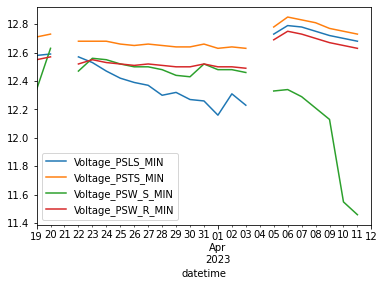

In [145]:
fig,ax=plt.subplots()
cols = AllData.columns
AllData[cols[cols.str.contains('Voltage')]].resample('D').min().plot(ax=ax)
# for plot in ['PSLS','PSTS','PSW']:
#     for treatment in ['R','S']:
#         ax.plot(AllData[f'Voltage_{plot}_{S}_MIN'])

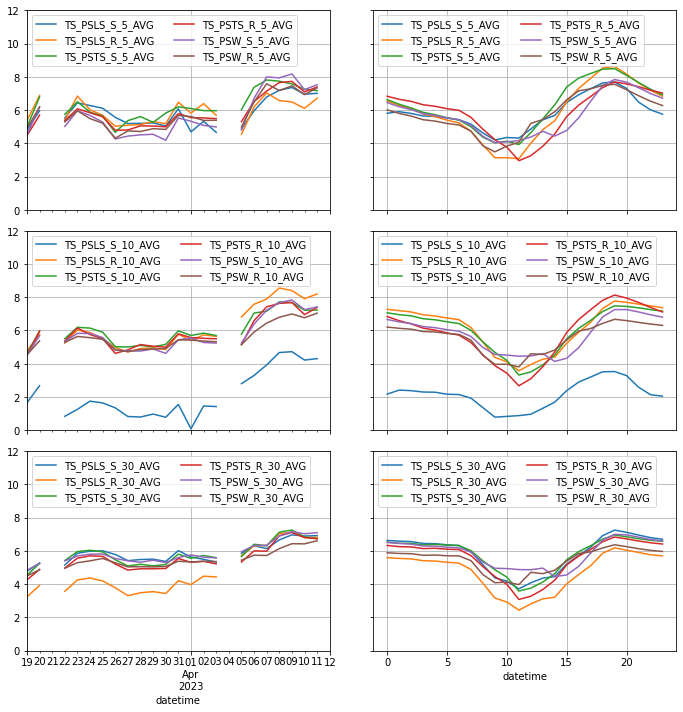

In [ ]:
Positions = ['PSLS_S','PSLS_R','PSTS_S','PSTS_R','PSW_S','PSW_R']


fig,ax=plt.subplots(3,2,figsize=(10,10),sharey=True,sharex='col')

depths = ['5','10','30']

ax[0,0].set_ylim(0,12)
for i,depth in enumerate(depths):
    cols = [f'TS_{pos}_{depth}_AVG' for pos in Positions]
    AllData[cols].resample('D').mean().plot(ax=ax[i,0])
    ax[i,0].legend(ncol=2,loc=2)
    ax[i,0].grid()
    AllData[cols].groupby(AllData.index.hour).mean().plot(ax=ax[i,1])
    ax[i,1].legend(ncol=2,loc=2)
    ax[i,1].grid()
plt.tight_layout()

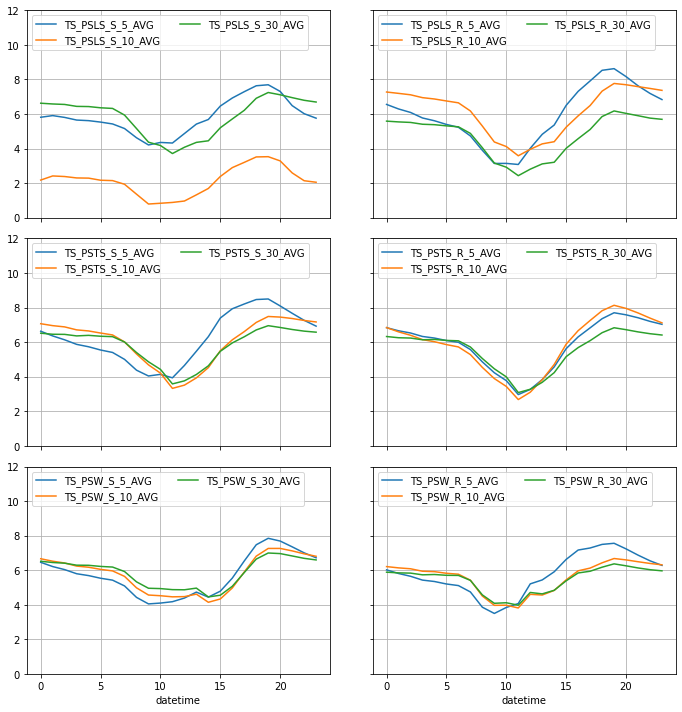

In [ ]:
Positions = ['PSLS','PSTS','PSW']


fig,ax=plt.subplots(3,2,figsize=(10,10),sharey=True,sharex='col')

depths = ['5','10','30']

ax[0,0].set_ylim(0,12)
for i,pos in enumerate(Positions):
    cols = [f'TS_{pos}_S_{depth}_AVG' for depth in depths]
    AllData[cols].groupby(AllData.index.hour).mean().plot(ax=ax[i,0])
    ax[i,0].legend(ncol=2,loc=2)
    ax[i,0].grid()
    cols = [f'TS_{pos}_R_{depth}_AVG' for depth in depths]
    AllData[cols].groupby(AllData.index.hour).mean().plot(ax=ax[i,1])
    ax[i,1].legend(ncol=2,loc=2)
    ax[i,1].grid()
plt.tight_layout()

Interval Start 20230318
                   u  ci95
TS_PSLS_S_5_STD  NaN   NaN
TS_PSLS_S_10_STD NaN   NaN
Interval Start 20230321
                   u  ci95
TS_PSLS_S_5_STD  NaN   NaN
TS_PSLS_S_10_STD NaN   NaN
Interval Start 20230404
                      u   ci95
TS_PSLS_S_5_STD     2.0    0.0
TS_PSLS_S_10_STD  190.5  101.8
Mean Diff: 188.5



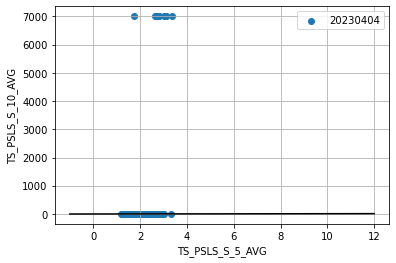

In [ ]:
from scipy import stats

def Compare(Subset):

       U = Subset.mean()   
       S = Subset.std()
       C = Subset.count()
       CI = np.round((S/C**.5)*stats.t.ppf(.95,C),2)
       C = C.to_frame()

       C['n'] = C[0]
       C['u'] = U
       C['std'] = S
       C['ci95'] = C['std']/C['n']**.5*stats.t.ppf(0.95,C['n'])

       print(C[['u','ci95']].round(1))

       print('Mean Diff:', C['u'].diff().dropna().round(1).values[0])
       print()


pos_x,treatment_x,depth_x,agg='PSLS','S','5','STD'
pos_y,treatment_y,depth_y,agg='PSLS','S','10','STD'

fig,ax=plt.subplots()

for i in AllData['Interval_ID'].dropna().unique():
       try:
              print('Interval Start',i)
              Subset = AllData.loc[AllData['Interval_ID']==i,
                     [f'TS_{pos_x}_{treatment_x}_{depth_x}_{agg}',
                     f'TS_{pos_y}_{treatment_y}_{depth_y}_{agg}']]
              Compare(Subset)

              ax.scatter(Subset[f'TS_{pos_x}_{treatment_x}_{depth_x}_{agg}'],
                     Subset[f'TS_{pos_y}_{treatment_y}_{depth_y}_{agg}'],
                     label=str(i)
                     )
       except:
              pass
ax.plot([-1,12],[-1,12],color='k')
ax.grid()
ax.set_xlabel(f'TS_{pos_x}_{treatment_x}_{depth_x}_AVG')
ax.set_ylabel(f'TS_{pos_y}_{treatment_y}_{depth_y}_AVG')

ax.legend()


In [ ]:
for plot in ['PSLS','PSTS','PSW']:
    for treatment in ['R','S']:
        pos_x,treatment_x,depth_x=plot,treatment,'5'
        pos_y,treatment_y,depth_y=plot,treatment,'10'


        Subset = AllData[[
            f'TS_{pos_x}_{treatment_x}_{depth_x}_AVG',f'TS_{pos_x}_{treatment_x}_{depth_x}_STD',
            f'TS_{pos_y}_{treatment_y}_{depth_y}_AVG',f'TS_{pos_y}_{treatment_y}_{depth_y}_STD',
            ]].copy()

        print(Subset.mean().round(2))
        print()

TS_PSLS_R_5_AVG     5.91
TS_PSLS_R_5_STD     0.98
TS_PSLS_R_10_AVG    6.16
TS_PSLS_R_10_STD    0.93
dtype: float64

TS_PSLS_S_5_AVG     5.83
TS_PSLS_S_5_STD     1.99
TS_PSLS_S_10_AVG    2.13
TS_PSLS_S_10_STD    3.06
dtype: float64

TS_PSTS_R_5_AVG     5.86
TS_PSTS_R_5_STD     0.33
TS_PSTS_R_10_AVG    5.87
TS_PSTS_R_10_STD    0.28
dtype: float64

TS_PSTS_S_5_AVG     6.25
TS_PSTS_S_5_STD     0.29
TS_PSTS_S_10_AVG    6.03
TS_PSTS_S_10_STD    0.37
dtype: float64

TS_PSW_R_5_AVG     5.76
TS_PSW_R_5_STD     0.06
TS_PSW_R_10_AVG    5.58
TS_PSW_R_10_STD    0.05
dtype: float64

TS_PSW_S_5_AVG     5.73
TS_PSW_S_5_STD     0.06
TS_PSW_S_10_AVG    5.78
TS_PSW_S_10_STD    0.06
dtype: float64



""
